# Preprocessing

In [3]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

Digunakan untuk mengatur direktori, manipulasi file, membuat grafik, dan menyiapkan data serta preprocessing untuk deep learning.

In [4]:
# Path asli dan target
original_dataset_dir = 'TrashType_Image_Dataset'
base_dir = 'sorted_dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [5]:
# Buat ulang folder
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)
os.makedirs(train_dir)
os.makedirs(val_dir)

In [6]:
# Saya Gunakan 2 kelas yaitu plastic dan paper
classes = ['plastic', 'paper']
valid_ext = ('.jpg', '.jpeg', '.png')

for class_name in classes:
    class_path = os.path.join(original_dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Filter hanya file gambar valid
    images = [img for img in os.listdir(class_path) if img.lower().endswith(valid_ext)]
    if len(images) < 2:
        print(f" Melewati kelas '{class_name}' karena hanya ada {len(images)} gambar.")
        continue

    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    for img in train_imgs:
        shutil.copyfile(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
    for img in val_imgs:
        shutil.copyfile(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))


In [7]:
# ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True

)

Found 860 images belonging to 2 classes.
Found 216 images belonging to 2 classes.


Digunakan untuk melakukan augmentasi data (rotasi, flipping, dll) dan menghasilkan batch data dari folder.

# CNN Model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [9]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

C:\Users\acer\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Training 

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [11]:
callbacks = [
    EarlyStopping(patience=7, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.2, min_lr=1e-6)
]

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=callbacks
)

C:\Users\acer\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.6833 - loss: 0.8964 - val_accuracy: 0.4491 - val_loss: 1.0743 - learning_rate: 5.0000e-04
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 919ms/step - accuracy: 0.7726 - loss: 0.4861 - val_accuracy: 0.4491 - val_loss: 1.2422 - learning_rate: 5.0000e-04
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 853ms/step - accuracy: 0.8187 - loss: 0.4344 - val_accuracy: 0.4491 - val_loss: 1.5416 - learning_rate: 5.0000e-04
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 866ms/step - accuracy: 0.7749 - loss: 0.4667 - val_accuracy: 0.4491 - val_loss: 1.3510 - learning_rate: 5.0000e-04
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 833ms/step - accuracy: 0.8194 - loss: 0.4320 - val_accuracy: 0.4491 - val_loss: 1.3668 - learning_rate: 1.0000e-04
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 813ms/step - accuracy: 0.8266 - loss: 0.3737 - val_accuracy: 0.4491 - val_loss: 1.1643 - learning_rate: 1.0000e-04
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 830ms/step - accura

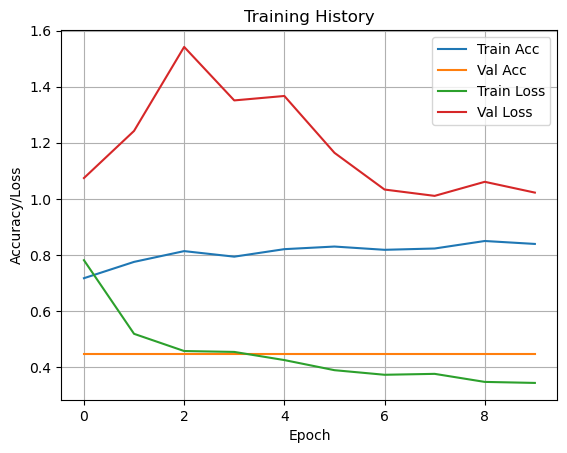

In [12]:
# Visualisasi training
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Simpan model
model.save('tess.h5')

# Prediksi

In [14]:
def view_classification_results(model, generator, num_images=10):
    import random
    class_labels = {v: k for k, v in generator.class_indices.items()}
    all_images = []
    all_labels = []
    for i in range(len(generator)):
        imgs, lbls = generator[i]
        all_images.extend(imgs)
        all_labels.extend(lbls)

    indices = random.sample(range(len(all_images)), min(num_images, len(all_images)))

    for i in indices:
        img = all_images[i]
        true_index = np.argmax(all_labels[i])
        prediction = model.predict(np.expand_dims(img, axis=0))
        pred_index = np.argmax(prediction)
        true_label = class_labels[true_index]
        pred_label = class_labels[pred_index]

        plt.imshow(img)
        plt.title(f"Predicted: {pred_label}, True: {true_label}")
        plt.axis('off')
        plt.show()

        print(f"Predicted: {pred_label}, True: {true_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


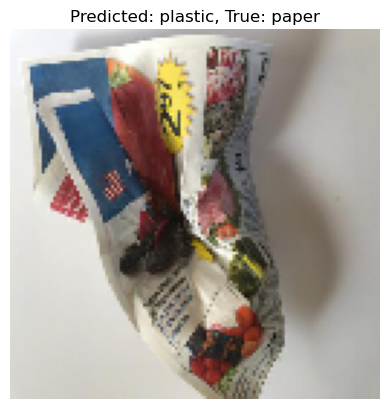

Predicted: plastic, True: paper
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


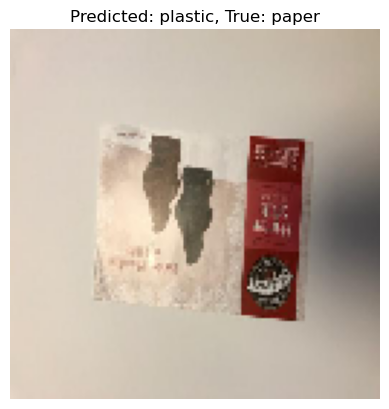

Predicted: plastic, True: paper
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


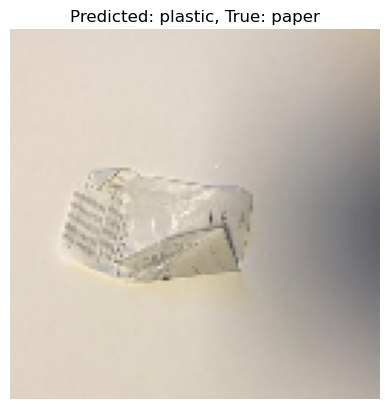

Predicted: plastic, True: paper
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


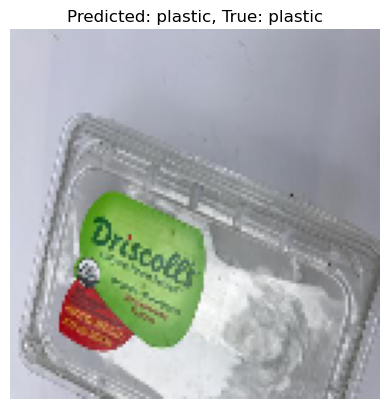

Predicted: plastic, True: plastic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


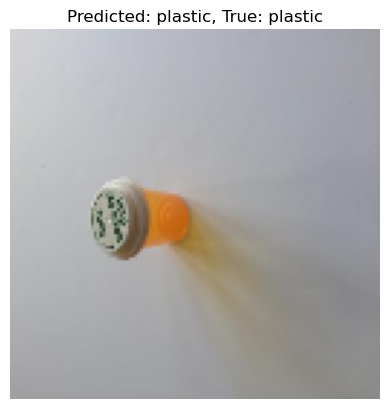

Predicted: plastic, True: plastic


In [15]:
view_classification_results(model, val_generator, num_images=5)

Model saya mengalami overfitting, karena:

Gejala	Penjelasan
Train Accuracy tinggi ==> Model terlalu fokus ke data training (hafal)

Val Accuracy stagnan ==> Model tidak belajar generalisasi terhadap data validasi

Train Loss menurun drastis ==> Pertanda model makin "menghafal" pola training

Val Loss tidak menurun ==> Kualitas prediksi di data validasi tidak membaik (atau malah memburuk)

Solusinya adalah:
- **Transfer Learning**: menggunakan model pralatih seperti MobileNetV2.
- **Dropout**: menonaktifkan neuron acak untuk mencegah overfitting.
- **EarlyStopping** dan **ReduceLROnPlateau**: menghentikan training lebih awal saat model tidak membaik.
""")

## CNN Menggunakan Transfer Learning

In [16]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [17]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(2, activation='softmax')(x)

model_tl = Model(inputs=base_model.input, outputs=output)
model_tl.compile(optimizer=Adam(learning_rate=0.0001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.2, min_lr=1e-6)
]

history_tl = model_tl.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 714ms/step - accuracy: 0.4562 - loss: 1.3927 - val_accuracy: 0.6713 - val_loss: 0.6470 - learning_rate: 1.0000e-04
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 493ms/step - accuracy: 0.6141 - loss: 0.8673 - val_accuracy: 0.7685 - val_loss: 0.4733 - learning_rate: 1.0000e-04
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 565ms/step - accuracy: 0.6652 - loss: 0.7469 - val_accuracy: 0.8148 - val_loss: 0.4260 - learning_rate: 1.0000e-04
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 502ms/step - accuracy: 0.7409 - loss: 0.5558 - val_accuracy: 0.8519 - val_loss: 0.3626 - learning_rate: 1.0000e-04
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 559ms/step - accuracy: 0.7613 - loss: 0.5410 - val_accuracy: 0.8565 - val_loss: 0.3337 - learning_rate: 1.0000e-04
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 475ms/step - accuracy: 0.7720 - loss: 0.4931 - val_accuracy: 0.8796 - val_loss: 0.3178 - learning_rate: 1.0000e-04
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 568ms/step - acc

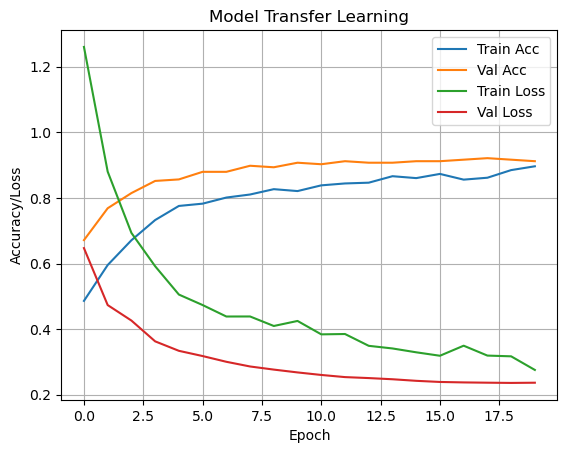

In [18]:
plt.plot(history_tl.history['accuracy'], label='Train Acc')
plt.plot(history_tl.history['val_accuracy'], label='Val Acc')
plt.plot(history_tl.history['loss'], label='Train Loss')
plt.plot(history_tl.history['val_loss'], label='Val Loss')
plt.title('Model Transfer Learning')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.grid(True)
plt.show()

Train Acc	Naik terus, mencapai ~88% ==> Model berhasil belajar dari data training

Val Acc	Naik dan stabil di ~88–90% ==> Model dapat menggeneralisasi dengan baik ke data baru

Train Loss	Menurun tajam	Model ==> semakin tepat pada prediksi di training

Val Loss	Turun konsisten	Model ==> tidak mengalami overfitting, validasi makin akurat

Model ini berhasil menghindari overfitting, dengan ciri-ciri:

Train & Val Accuracy seimbang dan tinggi

Train & Val Loss menurun dengan stabil

Tidak ada gap signifikan antara akurasi/loss training dan validasi

## Prediksi setelah menggunakan transfer learning

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import random

def view_classification_results(model, generator, num_images=10):
    # Mapping dari indeks ke nama kelas
    class_labels = {v: k for k, v in generator.class_indices.items()}

    # Ambil seluruh batch dari generator
    all_images = []
    all_labels = []

    for i in range(len(generator)):
        imgs, lbls = generator[i]
        all_images.extend(imgs)
        all_labels.extend(lbls)
        if len(all_images) >= num_images:
            break  # cukup ambil sebagian jika hanya untuk visualisasi

    # Pilih acak index gambar
    indices = random.sample(range(len(all_images)), min(num_images, len(all_images)))

    for i in indices:
        img = all_images[i]
        true_index = np.argmax(all_labels[i])
        prediction = model.predict(np.expand_dims(img, axis=0), verbose=0)
        pred_index = np.argmax(prediction)

        true_label = class_labels[true_index]
        pred_label = class_labels[pred_index]

        plt.imshow(img)
        plt.title(f"Predicted: {pred_label} | True: {true_label}")
        plt.axis('off')
        plt.show()

        print(f"[INFO] Predicted: {pred_label}, True: {true_label}")

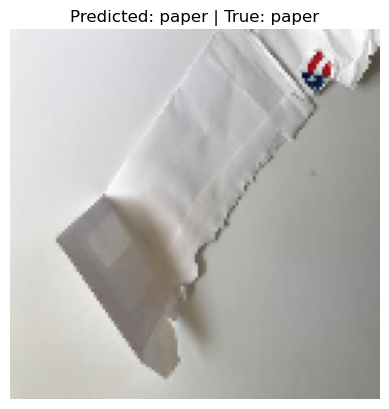

[INFO] Predicted: paper, True: paper


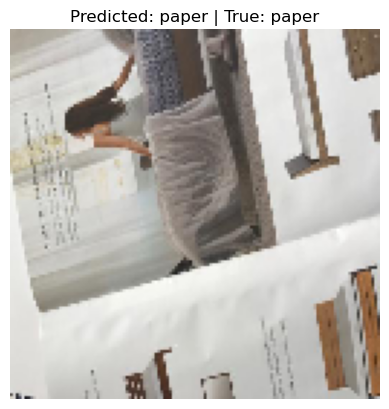

[INFO] Predicted: paper, True: paper


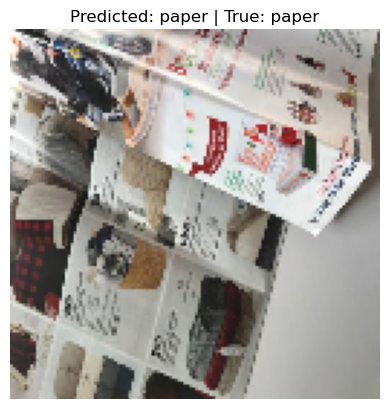

[INFO] Predicted: paper, True: paper


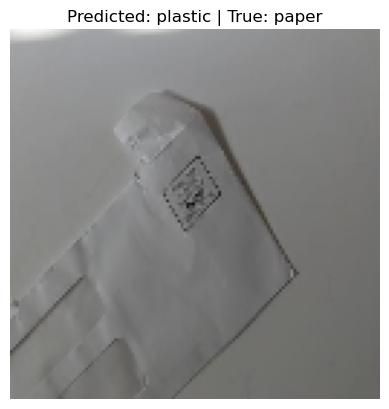

[INFO] Predicted: plastic, True: paper


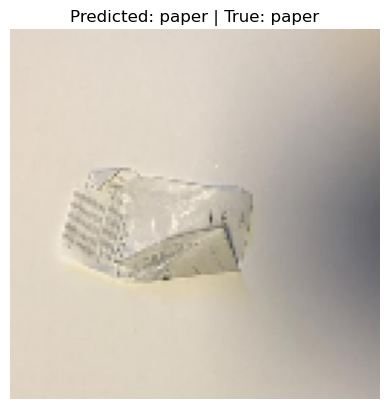

[INFO] Predicted: paper, True: paper


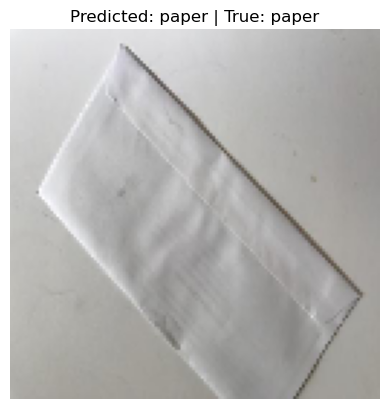

[INFO] Predicted: paper, True: paper


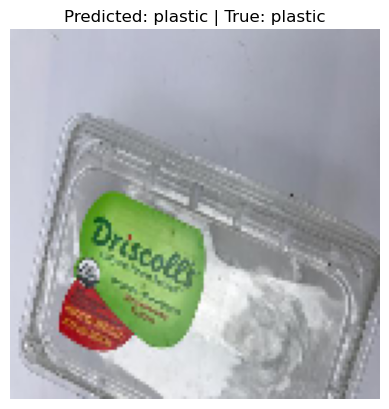

[INFO] Predicted: plastic, True: plastic


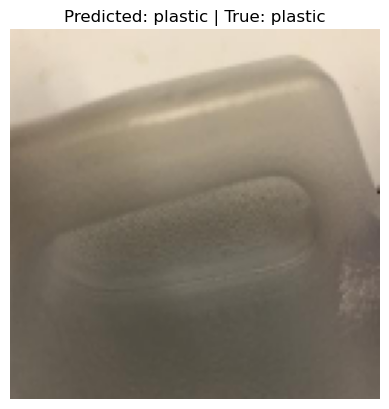

[INFO] Predicted: plastic, True: plastic


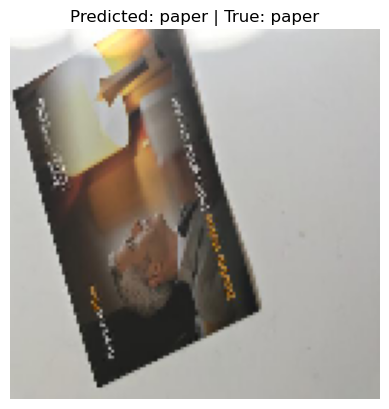

[INFO] Predicted: paper, True: paper


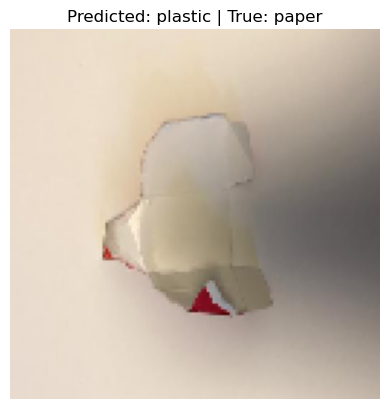

[INFO] Predicted: plastic, True: paper


In [22]:
view_classification_results(model_tl, val_generator, num_images=10)

Model memprediksi 10 gambar dan 9 gambar berhasil diprediksi dengan benar, menunjukkan sesuai dengan akurasi validasi yang diatas tadi yaitu 90%